In [2]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt

file_path = "CARBON LIVE BACKTEST_2024 (1).xlsx"

df_raw = pd.read_excel(file_path, sheet_name="backtest2024_delta-delta-logic", usecols="A:O",skiprows=20, header=0)

new_header = df_raw.iloc[0]
df_raw = df_raw[1:].copy()
df_raw.columns = new_header
df_raw.reset_index(drop=True, inplace=True)
df_raw = df_raw.drop(columns=["Symbol","Date"])
df_raw.head(10)

,date,Hard Coal,Lignite,Gas,Oil,Industry Power and Waste,Daily Emissions,Close,Open,High,Low,Volume,OpenInterest
0,2023-10-10 00:00:00,435016,698760,746909,26715,249597,2156997,81.58,84.82,81.87,85.06,30660,324524
1,2023-10-11 00:00:00,342011,489121,611770,24922,200701,1668524,83.42,84.12,84.39,85.03,30964,328918
2,2023-10-12 00:00:00,468903,713773,706780,25539,250443,2165437,83.45,85.23,83.78,85.7,19116,330049
3,2023-10-13 00:00:00,318024,533092,502791,21677,189876,1565459,84.73,85.95,85.2,86.6,26594,329794
4,2023-10-16 00:00:00,505570,769745,675047,26787,257065,2234214,82.95,83.35,85.26,85.98,25036,324123
5,2023-10-17 00:00:00,513512,828226,616104,27261,257357,2242460,81.45,82.55,83.29,83.71,21167,325279
6,2023-10-18 00:00:00,374605,724037,530471,27607,220548,1877268,81.5,81.86,82.5,83.35,20872,327174
7,2023-10-19 00:00:00,408106,671376,537462,27673,219024,1863643,80.84,81.76,81.7,82.25,19481,327814
8,2023-10-20 00:00:00,348413,569193,438370,22522,189114,1567612,81.04,81.41,81.98,82.5,20321,324672
9,2023-10-23 00:00:00,503481,794264,708801,30510,261760,2298816,80.06,80.5,81.39,81.5,20762,327172


In [3]:
import numpy as np

df= df_raw.copy()
# 1: Compute 15-day rolling correlation between each demand column and Close
demand_columns = ["Hard Coal", "Lignite", "Gas", "Oil", 
                  "Industry Power and Waste", "Daily Emissions"]

for col in demand_columns:
    df[f"corr_{col}"] = df[col].rolling(15).corr(df["Close"])

# 2: Calculate daily deltas for each demand variable
for col in demand_columns:
    df[f"delta_{col}"] = df[col] - df[col].shift(1)

# 3: Apply correlation threshold logic to generate per-feature signals
threshold = -0.55

def generate_signal(corr, delta):
    if pd.isna(corr) or pd.isna(delta):
        return 0
    if corr < threshold:
        return 1 if delta < 0 else -1
    return 0

for col in demand_columns:
    df[f"signal_{col}"] = [
        generate_signal(c, d) for c, d in zip(df[f"corr_{col}"], df[f"delta_{col}"])
    ]

# 4: Combine signals by voting
signal_columns = [f"signal_{col}" for col in demand_columns]
df["final_signal"] = df[signal_columns].sum(axis=1)
df["final_signal"] = df["final_signal"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# 5: Calculate returns based on Close(t-1) and Close(t)
df["Close_t-1"] = df["Close"].shift(1)
df["return"] = df["Close"].pct_change()
df["strategy_return"] = df["final_signal"].shift(1) * df["return"]

df[["date", "final_signal", "Close", "Close_t-1", "return", "strategy_return"] + signal_columns].head(10)


C:\Users\Lenovo Gaming\AppData\Local\Temp\ipykernel_14892\3015227963.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["return"] = df["Close"].pct_change()


,date,final_signal,Close,Close_t-1,return,strategy_return,signal_Hard Coal,signal_Lignite,signal_Gas,signal_Oil,signal_Industry Power and Waste,signal_Daily Emissions
0,2023-10-10 00:00:00,0,81.58,None,NaN,NaN,0,0,0,0,0,0
1,2023-10-11 00:00:00,0,83.42,81.58,0.022555,0.0,0,0,0,0,0,0
2,2023-10-12 00:00:00,0,83.45,83.42,0.000360,0.0,0,0,0,0,0,0
3,2023-10-13 00:00:00,0,84.73,83.45,0.015339,0.0,0,0,0,0,0,0
4,2023-10-16 00:00:00,0,82.95,84.73,-0.021008,-0.0,0,0,0,0,0,0
5,2023-10-17 00:00:00,0,81.45,82.95,-0.018083,-0.0,0,0,0,0,0,0
6,2023-10-18 00:00:00,0,81.5,81.45,0.000614,0.0,0,0,0,0,0,0
7,2023-10-19 00:00:00,0,80.84,81.5,-0.008098,-0.0,0,0,0,0,0,0
8,2023-10-20 00:00:00,0,81.04,80.84,0.002474,0.0,0,0,0,0,0,0
9,2023-10-23 00:00:00,0,80.06,81.04,-0.012093,-0.0,0,0,0,0,0,0


In [4]:
# 6: Calculate cumulative PNL and performance metrics
df["cumulative_return"] = (1 + df["strategy_return"].fillna(0)).cumprod() - 1

pnl = df["cumulative_return"].iloc[-1]
strategy_returns = df["strategy_return"].dropna()
num_trades = (df["final_signal"].shift(1) != 0).sum()
profitable_trades = (strategy_returns > 0).sum()
loss_trades = (strategy_returns < 0).sum()
no_trades = (df["final_signal"].shift(1) == 0).sum()
accuracy = profitable_trades / (profitable_trades + loss_trades) if (profitable_trades + loss_trades) > 0 else 0

# assuming risk-free rate = 0
sharpe_ratio = strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else 0
volatility = strategy_returns.std()
cumulative_curve = (1 + strategy_returns.fillna(0)).cumprod()
drawdown = cumulative_curve.cummax() - cumulative_curve
max_drawdown = drawdown.max()
max_drawup = cumulative_curve.max() - 1

results_summary = {
    "PNL": pnl,
    "Accuracy": accuracy,
    "Number of Trades": num_trades,
    "Profitable Trades": profitable_trades,
    "Losing Trades": loss_trades,
    "No Trades": no_trades,
    "Sharpe Ratio": sharpe_ratio,
    "Volatility": volatility,
    "Max Drawdown": max_drawdown,
    "Max Drawup": max_drawup
}

print("Results Summary:")
for key, value in results_summary.items():
    print(f"{key}: {value:.2f}")

Results Summary:
PNL: 0.09
Accuracy: 0.51
Number of Trades: 84.00
Profitable Trades: 41.00
Losing Trades: 40.00
No Trades: 196.00
Sharpe Ratio: 0.03
Volatility: 0.01
Max Drawdown: 0.14
Max Drawup: 0.14


The strategy's low Sharpe ratio (~0.03) and high drawdown (~14%) suggest that the current correlation-based signal lacks strength. This may be due to:
- The correlation threshold being too strict
- Signals being too rare or noisy
- Industrial demand not having a strong or consistent relationship with short-term carbon price moves

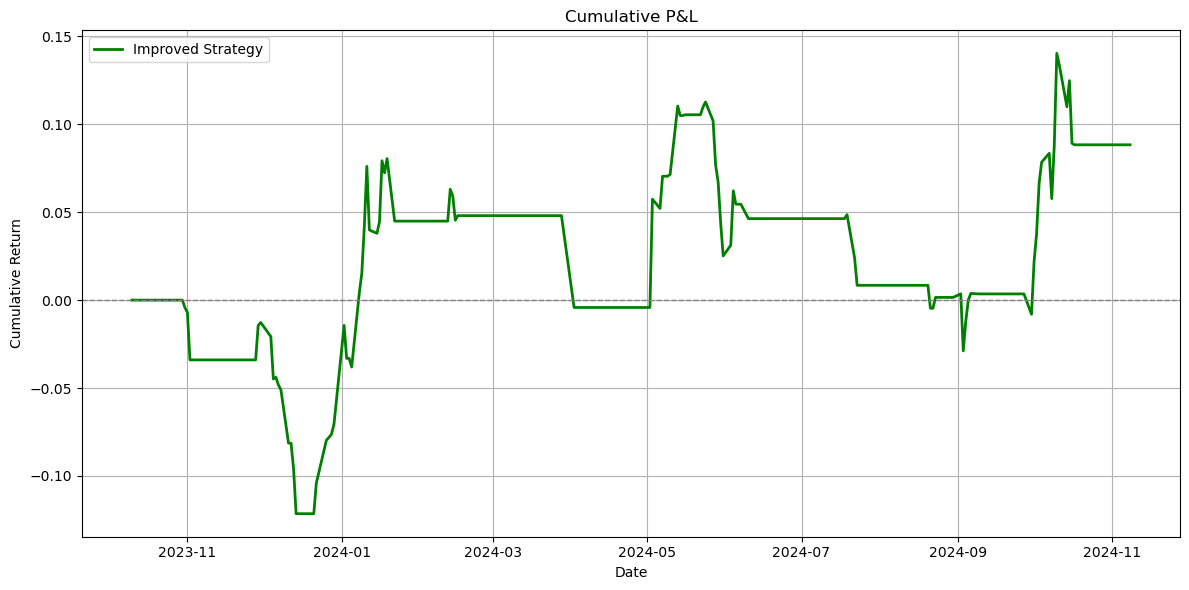

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["cumulative_return"], label="Improved Strategy", color="green", linewidth=2)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Cumulative P&L")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Logistic regression

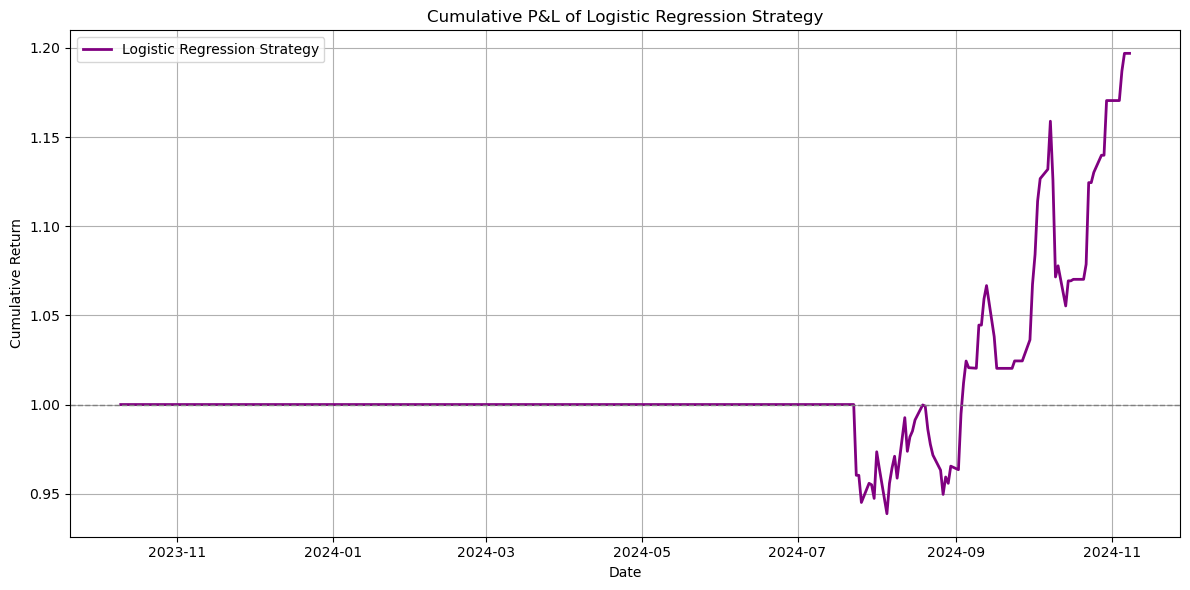

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

features = []
for col in demand_columns:
    df[f"z_{col}"] = (df[col] - df[col].shift(1)) / df[col].rolling(5).std()
    df[f"corr_{col}"] = df[col].rolling(15).corr(df["Close"])
    features.extend([f"z_{col}", f"corr_{col}"])

df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

ml_data = df[features + ["target", "return", "date"]].dropna()
X = ml_data[features]
y = ml_data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

probabilities = logreg.predict_proba(X_test_scaled)[:, 1]
predicted_signal = np.where(probabilities > 0.55, 1, np.where(probabilities < 0.45, -1, 0))

df.loc[X_test.index, "ml_signal"] = predicted_signal

df["ml_strategy_return"] = df["ml_signal"].shift(1) * df["return"]
df["cumulative_ml"] = (1 + df["ml_strategy_return"].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["cumulative_ml"], label="Logistic Regression Strategy", color="purple", linewidth=2)
plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.title("Cumulative P&L of Logistic Regression Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate performance metrics
ml_returns = df.loc[X_test.index, "ml_strategy_return"].dropna()
ml_pnl = df.loc[X_test.index, "cumulative_ml"].iloc[-1]
ml_accuracy = accuracy_score(y_test, (df.loc[X_test.index, "ml_signal"] > 0).astype(int))
ml_num_trades = (df.loc[X_test.index, "ml_signal"] != 0).sum()
ml_profitable_trades = (ml_returns > 0).sum()
ml_losing_trades = (ml_returns < 0).sum()
ml_no_trades = (df.loc[X_test.index, "ml_signal"] == 0).sum()
ml_sharpe = ml_returns.mean() / ml_returns.std()
ml_volatility = ml_returns.std()
ml_cum_curve = (1 + ml_returns).cumprod()
ml_drawdown = ml_cum_curve.cummax() - ml_cum_curve
ml_max_drawdown = ml_drawdown.max()
ml_max_drawup = ml_cum_curve.max() - 1

ml_results = {
    "PNL": ml_pnl,
    "Accuracy": ml_accuracy,
    "Number of Trades": ml_num_trades,
    "Profitable Trades": ml_profitable_trades,
    "Losing Trades": ml_losing_trades,
    "No Trades": ml_no_trades,
    "Sharpe Ratio": ml_sharpe,
    "Volatility": ml_volatility,
    "Max Drawdown": ml_max_drawdown,
    "Max Drawup": ml_max_drawup
}

print("\nLogistic Regression Results Summary:")
for key, value in ml_results.items():
    print(f"{key}: {value:.2f}")



Logistic Regression Results Summary:
PNL: 1.20
Accuracy: 0.59
Number of Trades: 59.00
Profitable Trades: 36.00
Losing Trades: 23.00
No Trades: 21.00
Sharpe Ratio: 0.15
Volatility: 0.02
Max Drawdown: 0.10
Max Drawup: 0.20


In [8]:
comparison_df = pd.DataFrame({
    "Metric": list(ml_results.keys()),
    "Improved Strategy": [
        results_summary["PNL"],
        results_summary["Accuracy"],
        results_summary["Number of Trades"],
        results_summary["Profitable Trades"],
        results_summary["Losing Trades"],
        results_summary["No Trades"],
        results_summary["Sharpe Ratio"],
        results_summary["Volatility"],
        results_summary["Max Drawdown"],
        results_summary["Max Drawup"]
    ],
    "Logistic Regression": list(ml_results.values())
})

# Format numeric values to 4 decimal places
for col in comparison_df.columns[1:]:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.2f}" if isinstance(x, (float, int)) else x)

# Print formatted table
print("\nComparison of Strategies:")
print(comparison_df.to_string(index=False))



Comparison of Strategies:
           Metric Improved Strategy Logistic Regression
              PNL              0.09                1.20
         Accuracy              0.51                0.59
 Number of Trades             84.00               59.00
Profitable Trades             41.00               36.00
    Losing Trades             40.00               23.00
        No Trades            196.00               21.00
     Sharpe Ratio              0.03                0.15
       Volatility              0.01                0.02
     Max Drawdown              0.14                0.10
       Max Drawup              0.14                0.20


### Feature importance analysis

In [ ]:
# Extract feature names and corresponding coefficients
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logreg.coef_[0]
})

feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance_sorted = feature_importance.sort_values("Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")

print("\nFeature Importance:")
print(feature_importance_sorted.to_string(index=True))



Feature Importance:
                          Feature  Coefficient
3                    corr_Lignite    -0.752142
9   corr_Industry Power and Waste     0.570057
5                        corr_Gas    -0.520244
1                  corr_Hard Coal     0.358639
11           corr_Daily Emissions     0.299717
7                        corr_Oil     0.277325
0                     z_Hard Coal    -0.263731
8      z_Industry Power and Waste    -0.166851
10              z_Daily Emissions     0.164852
2                       z_Lignite     0.082611
4                           z_Gas     0.011432
6                           z_Oil     0.007499




| Rank | Feature                         | Coefficient | Interpretation                                                                 |
|------|----------------------------------|-------------|---------------------------------------------------------------------------------|
| 1    | corr_Lignite                     | –0.7521     | Strong negative correlation → drop in demand suggests price increase           |
| 2    | corr_Industry Power and Waste   | +0.5701     | Positive correlation → increase in demand supports price rise                  |
| 3    | corr_Gas                         | –0.5202     | Strong negative correlation → drop in gas demand linked to price increase      |
| 4    | corr_Hard Coal                   | +0.3586     | Positive correlation → increased demand may signal higher price                |
| 5    | corr_Daily Emissions            | +0.2997     | Increase in emissions correlates with rising prices                            |
| 6    | corr_Oil                         | +0.2773     | Mild positive relationship between oil demand and price                        |
| 7    | z_Hard Coal                      | –0.2637     | Sharp drop in hard coal demand (adjusted for volatility) signals price rise    |
| 8    | z_Industry Power and Waste       | –0.1669     | Sharp fall in industrial demand also considered bearish                        |
| 9    | z_Daily Emissions                | +0.1649     | Increased emissions, beyond norm, support bullish signal                       |
| 10   | z_Lignite                        | +0.0826     | Slightly rising Lignite demand considered weak bullish signal                  |
| 11   | z_Gas                            | +0.0114     | Almost neutral effect                                                          |
| 12   | z_Oil                            | +0.0075     | Insignificant influence                                                        |


In [ ]:
probabilities = logreg.predict_proba(X_test_scaled)[:, 1]

# Top 30% confidence → buy; bottom 30% → sell; otherwise hold
high_thresh = np.percentile(probabilities, 70)
low_thresh = np.percentile(probabilities, 30)

df.loc[X_test.index, "dynamic_signal"] = np.where(
    probabilities > high_thresh, 1,
    np.where(probabilities < low_thresh, -1, 0)
)

df["dynamic_strategy_return"] = df["dynamic_signal"].shift(1) * df["return"]
df["cumulative_dynamic"] = (1 + df["dynamic_strategy_return"].fillna(0)).cumprod()

dyn_returns = df.loc[X_test.index, "dynamic_strategy_return"].dropna()
dyn_pnl = df.loc[X_test.index, "cumulative_dynamic"].iloc[-1]
dyn_accuracy = accuracy_score(y_test, (df.loc[X_test.index, "dynamic_signal"] > 0).astype(int))
dyn_num_trades = (df.loc[X_test.index, "dynamic_signal"] != 0).sum()
dyn_profitable_trades = (dyn_returns > 0).sum()
dyn_losing_trades = (dyn_returns < 0).sum()
dyn_no_trades = (df.loc[X_test.index, "dynamic_signal"] == 0).sum()
dyn_sharpe = dyn_returns.mean() / dyn_returns.std()
dyn_volatility = dyn_returns.std()
dyn_cum_curve = (1 + dyn_returns).cumprod()
dyn_drawdown = dyn_cum_curve.cummax() - dyn_cum_curve
dyn_max_drawdown = dyn_drawdown.max()
dyn_max_drawup = dyn_cum_curve.max() - 1

dynamic_results = {
    "PNL": dyn_pnl,
    "Accuracy": dyn_accuracy,
    "Number of Trades": dyn_num_trades,
    "Profitable Trades": dyn_profitable_trades,
    "Losing Trades": dyn_losing_trades,
    "No Trades": dyn_no_trades,
    "Sharpe Ratio": dyn_sharpe,
    "Volatility": dyn_volatility,
    "Max Drawdown": dyn_max_drawdown,
    "Max Drawup": dyn_max_drawup
}

print("\nDynamic Threshold Results Summary:")
for key, value in dynamic_results.items():
    print(f"{key}: {value:.2f}")    


Dynamic Threshold Results Summary:
PNL: 1.13
Accuracy: 0.59
Number of Trades: 48.00
Profitable Trades: 28.00
Losing Trades: 20.00
No Trades: 32.00
Sharpe Ratio: 0.11
Volatility: 0.01
Max Drawdown: 0.10
Max Drawup: 0.13


Compared to the fixed-threshold logistic regression model:

PNL is still very strong at 113%, close to the previous best.

Sharpe ratio improves over the improved rule-based strategy and is only slightly below the fixed-threshold model.

Max Drawdown is the lowest yet among all models (9.97%).

Number of trades is reduced to 48 → the strategy only trades when there's high confidence (top or bottom 30% probability).

This confirms that using probability-based signal filtering helps isolate high-confidence trades, boosting quality while controlling risk.